Данные можно взять тут: https://disk.yandex.ru/d/q1G0W-taR0TSxw

In [12]:
import pandas as pd

data = pd.read_csv('C:/Users/matvey/Documents/chess_data/full_labeled.csv')
data.head()

,id,white_elo,black_elo,moves,marks
0,787zsVup,1638.0,1851.0,e2e4 c7c6 f2f4 d7d5 e4d5 c6d5 g1f3 b8c6 d2d3 g...,"47,53"
1,F8M8OS71,1760.0,1823.0,e2e4 c7c5 g1f3 d7d6 c2c3 g8f6 d2d3 a7a6 b1d2 e...,"52,56"
2,MQSyb3KW,1877.0,1909.0,e2e4 c7c5 c2c3 d7d6 d2d4 c5d4 c3d4 b7b6 b1c3 c...,"126,130"
3,4MWQCxQ6,1741.0,1625.0,e2e4 e7e5 d2d3 b8c6 g1f3 f8c5 f1e2 g8f6 e1g1 e...,"31,35"
4,e9AY2m5j,1766.0,1733.0,e2e4 c7c5 f1c4 e7e6 g1f3 d7d5 e4d5 e6d5 c4b5 b...,"49,55"


Напишем функцию для предобработки данных

In [13]:
import chess
import numpy as np
import pandas as pd
from typing import Union

def prepare_data(data: Union[pd.DataFrame, dict, pd.Series], board2vec) -> tuple:
    """
    Обрабатывает данные для модели, принимая как DataFrame, так и отдельные записи.

    Args:
        data: Входные данные - DataFrame или отдельная запись (dict/Series)
        board2vec: Функция кодирования досок

    Returns:
        Кортеж (признаки, целевая_переменная)
    """
    # Преобразуем одиночные записи в DataFrame
    if not isinstance(data, pd.DataFrame):
        data = pd.DataFrame([data] if not isinstance(data, list) else data)

    data['moves'] = data['moves'].str.split(' ')
    data['marks'] = data['marks'].str.split(',')
    dfs = []
    for row in data.itertuples(index=False):
        # Извлекаем параметры из строки
        start, end = map(int, row.marks)
        board = chess.Board()
        boards = []
        target = np.zeros(shape=(len(row.moves),))
        target[start:end] = 1

        # Генерируем последовательность досок и целевых значений
        for move in row.moves:
            board.push(chess.Move.from_uci(move))
            boards.append(board.copy())

        # Кодируем доски и формируем DataFrame
        encoded = board2vec(boards)
        df = pd.DataFrame(np.vstack(encoded))
        df['white_elo'] = row.white_elo
        df['black_elo'] = row.black_elo
        df['target'] = target

        dfs.append(df)

    # Объединяем все данные
    result = pd.concat(dfs, ignore_index=True)
    result.columns = result.columns.astype(str)

    return result.drop(columns='target'), result['target']

Напишем функцию для тренировки и оценки модели. Будем считать все метрики подряд, так информативнее. Моделька - LightGBM бустер, потому что она быстро обучается и имеет неплохое качество

In [14]:
import lightgbm as lgb
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    confusion_matrix
)

def validate(y_pred, y_true):
    # Оцениваем качество модели
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    conf_matrix = confusion_matrix(y_true, y_pred)

    # Выводим метрики качества
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print("Confusion Matrix:")
    print(conf_matrix)


def make_lgb(X, y):
    train_data = lgb.Dataset(X, label=y)
    # Параметры модели
    params = {
        'objective': 'binary',  # Для бинарной классификации
        'metric': 'binary_logloss',
        'boosting_type': 'gbdt',
        'num_leaves': 40,
        'learning_rate': 0.01
    }

    return lgb.train(params, train_data, num_boost_round=500)

Собираем тренировочную и тестовую выборки

In [15]:
# Муть с относительными импортами
import sys
from pathlib import Path
module_path = str(Path.cwd().parent.parent)
if module_path not in sys.path:
    sys.path.append(module_path)
from experiments.experiment_04.inference import board2vec

X_train, y_train = prepare_data(data.sample(100, random_state=42), board2vec)
X_test, y_test = prepare_data(data.sample(10, random_state=52), board2vec)
print(X_train.shape, X_test.shape)

(9167, 130) (869, 130)


Обучаем и валидируем модель

In [16]:
model = make_lgb(X_train, y_train)
validate(model.predict(X_test) > 0.2, y_test)

[LightGBM] [Info] Number of positive: 460, number of negative: 8707
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0,006476 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 32825
[LightGBM] [Info] Number of data points in the train set: 9167, number of used features: 130
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0,050180 -> initscore=-2,940656
[LightGBM] [Info] Start training from score -2,940656
Accuracy: 0.9459
Precision: 0.2400
Recall: 0.1765
F1 Score: 0.2034
Confusion Matrix:
[[816  19]
 [ 28   6]]


Посмотрим как модель оценивает вероятность интересности хода

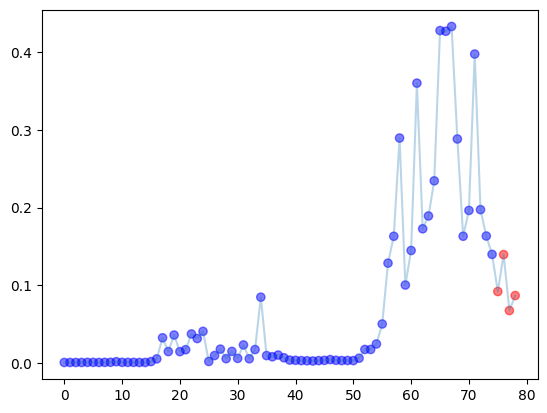

In [28]:
import matplotlib.pyplot as plt

X, y = prepare_data(data.sample(1), board2vec)
y_pred = model.predict(X)
plt.scatter(x=np.arange(y_pred.shape[0]), y=y_pred, c=y, cmap='bwr', alpha=0.5)
plt.plot(y_pred, alpha=0.3)
plt.show()

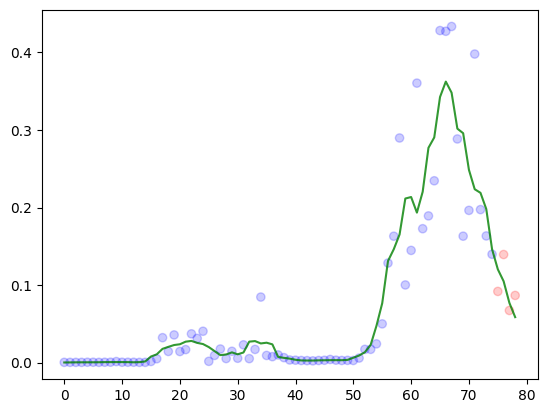

In [29]:
# Применяем сглаживание с помощью свёртки
kernel = np.ones(5) / 5
smoothed = np.convolve(y_pred, kernel, mode='same')
plt.scatter(x=np.arange(y_pred.shape[0]), y=y_pred, c=y, cmap='bwr', alpha=0.2)
plt.plot(smoothed, alpha=0.8, c='green')
plt.show()

(array([23.61357813]), array([0.05867642]), array([54.38642187]), array([78.]))


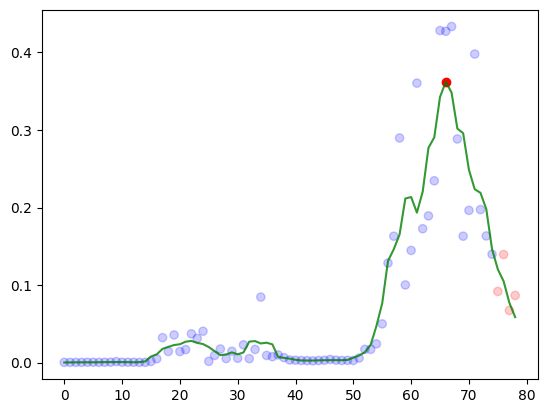

In [39]:
from scipy.signal import find_peaks
from scipy.signal import peak_widths

threshold = max(0.1, np.percentile(smoothed, 100 - 7))
peaks, properties = find_peaks(smoothed, height=threshold, distance=10)
results_half = peak_widths(smoothed, peaks, rel_height=1)
print(results_half)

x = np.arange(len(y_pred))
plt.plot(x[peaks], smoothed[peaks], 'ro', label='Пики')
plt.scatter(x=np.arange(y_pred.shape[0]), y=y_pred, c=y, cmap='bwr', alpha=0.2)
plt.plot(smoothed, alpha=0.8, c='green')
plt.show()

Наконец, выход модели можно подвергнуть постобработки в надежде на улучшение качества

In [ ]:
from scipy.signal import find_peaks
from scipy.signal import peak_widths
from math import ceil, floor


def pseudo_inference(model: lgb.Booster, sample: pd.DataFrame, embedding_function, alpha: float, show = False):
    X, y_true = prepare_data(sample, embedding_function)
    y_pred = model.predict(X)

    # Применяем сглаживание с помощью свёртки
    kernel = np.ones(3) / 3
    smoothed = np.convolve(y_pred, kernel, mode='same')

    threshold = max(0.1, np.percentile(smoothed, 100 - 7))
    peaks, _ = find_peaks(smoothed, height=threshold, distance=10)
    widths, _, left_ips, right_ips = peak_widths(smoothed, peaks, rel_height=1)
    valid_mask = (widths > 4) & (widths < 40)

    # Применяем маску ко всем связанным массивам
    left_ips = left_ips[valid_mask]
    right_ips = right_ips[valid_mask]

    y_result = np.zeros_like(y_pred)
    
    # Векторное обновление значений в y_result
    left_bounds = np.floor(left_ips).astype(int)
    right_bounds = np.ceil(right_ips).astype(int) + 1

    for start, end in zip(left_bounds, right_bounds):
        y_result[start:end] = 1

    if show:
        plt.scatter(x=np.arange(y_pred.shape[0]), y=y_result, c=y_true, cmap='bwr')
        plt.scatter(x=np.arange(y_pred.shape[0]), y=y_pred, alpha=0.8, c='k')
        plt.show()
    return y_result, y_true, y_result


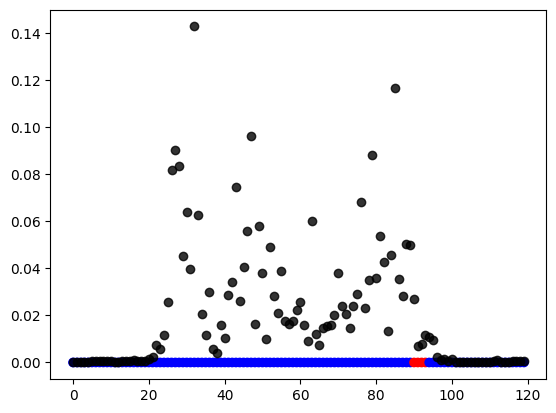

In [51]:
_ = pseudo_inference(model, data.sample(1), board2vec, alpha=0.3, show=True)

И теперь посмотрим, улучшилось ли качество глобально

In [32]:
precisions = []
recalls = []
for _ in range(200):
    y_pred, y_true, _ = pseudo_inference(model, data.sample(1), board2vec, alpha=0.3)
    precisions.append(precision_score(y_true, y_pred, zero_division=0))
    recalls.append(recall_score(y_true, y_pred))
print(f'Precision: {sum(precisions) / len(precisions):.4f}, Recall: {sum(recalls) / len(recalls):.4f}')

Precision: 0.1532, Recall: 0.3905
